In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import (balanced_accuracy_score, ConfusionMatrixDisplay, 
                            recall_score, precision_score, f1_score)

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTEN
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# reading the youth model dataset 
youth_model = pd.read_csv("datasets/youth_model.csv")

youth_model.head()

,hmlsmorethan1Yr,dv_neglect,dv_physical,dv_physical_rel,dv_sexual_rel,subsabuse,drugabuse,SPA
0,1,1,1,1,0,0,0,4
1,1,0,0,0,1,0,0,4
2,1,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,4


# Normal Logistic Regression

In [3]:
# creating our X and y

features = ['dv_neglect', 'dv_physical', 'dv_physical_rel', 'dv_sexual_rel', 'subsabuse', 'drugabuse', 'SPA']

X = youth_model[features]
y = youth_model['hmlsmorethan1Yr']

In [4]:
# Train Test Split


X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=y)

In [5]:
#scale data
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [6]:
logr = LogisticRegression(max_iter=1_000)
logr.fit(X_train_ss, y_train)

LogisticRegression(max_iter=1000)

In [7]:
# train score with regular Logistic Regression
logr.score(X_train_ss, y_train)

0.6555070354196991

In [8]:
# test score with regular Logistic Regression
logr.score(X_test_ss, y_test)

0.6569767441860465

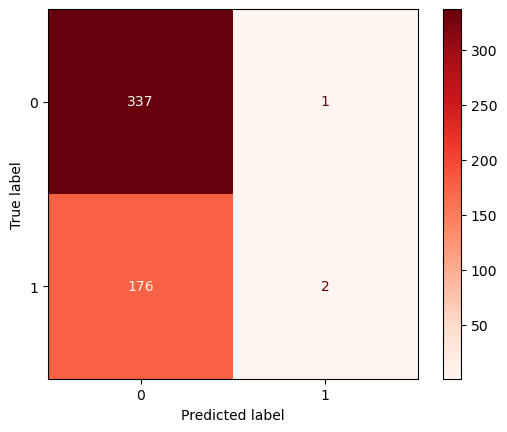

In [9]:
ConfusionMatrixDisplay.from_estimator(logr, X_test_ss, y_test, cmap = 'Reds');

In [10]:
preds1 = logr.predict(X_test_ss)
preds1[20:40]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [11]:
def evaluation(X_test, y_test, preds, model):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    
    b_acc = balanced_accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds, pos_label = 1)
    prec = precision_score(y_test, preds, pos_label = 1)
    f1 = f1_score(y_test, preds, pos_label = 1)

    print(f'balanced_accuracy: {b_acc}')
    print(f'recall: {recall}')
    print(f'precision: {prec}')
    print(f'f1 score: {f1}')

    return {
        'balanced_accuracy': b_acc,
        'recall': recall,
        'precision': prec,
        'f1_score': f1
    }

In [12]:
scores = []

balanced_accuracy: 0.5041386875872614
recall: 0.011235955056179775
precision: 0.6666666666666666
f1 score: 0.022099447513812154


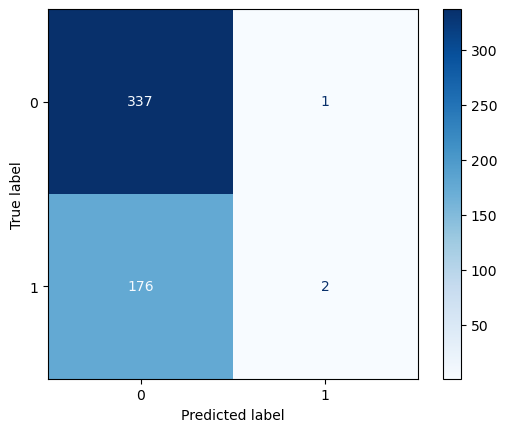

In [13]:
scores.append(evaluation(X_test_ss, y_test, preds1, logr))

# Null Model

In [14]:
# hmlsmorethan1Yr
# Whether homeless more than 1 year this time
# 0 - No
# 1 - Yes
youth_model['hmlsmorethan1Yr'].value_counts(normalize=True)

hmlsmorethan1Yr
0    0.655413
1    0.344587
Name: proportion, dtype: float64

In [15]:
# predicting null test
# predicting
null_pred = [0]*len(youth_model['hmlsmorethan1Yr'])

In [16]:
# because we are dealing with imbalanced data with the target variable
# make the null model the baseline instead of the one initially done in EDA
# which in this case is 0.5 - see if we can go higher than this score
balanced_accuracy_score(youth_model['hmlsmorethan1Yr'], null_pred)

0.5

# Oversample the minority class

In [65]:
pipe = make_pipeline(RandomOverSampler(random_state=42),
                    LogisticRegression(max_iter=1000))

In [18]:
pipe.fit(X_train_ss, y_train)

Pipeline(steps=[('randomoversampler', RandomOverSampler(random_state=42)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

balanced_accuracy: 0.5335915165215079
recall: 0.4606741573033708
precision: 0.3813953488372093
f1 score: 0.41730279898218836


{'balanced_accuracy': 0.5335915165215079,
 'recall': 0.4606741573033708,
 'precision': 0.3813953488372093,
 'f1_score': 0.41730279898218836}

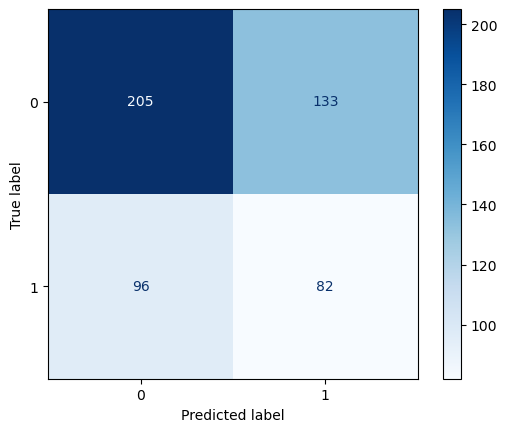

In [19]:
evaluation(X_test_ss, y_test, pipe.predict(X_test_ss), pipe)

In [66]:
gs = GridSearchCV(pipe,
                 param_grid=
                  {'randomoversampler__sampling_strategy' : [.25, .5, .75, 1.0]},
                 n_jobs=-1)

In [67]:
gs.fit(X_train_ss, y_train)

C:\Users\danie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\danie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\danie\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\danie\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 322, in fit
    Xt, yt = self._fit(X, y,

GridSearchCV(estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'randomoversampler__sampling_strategy': [0.25, 0.5,
                                                                  0.75, 1.0]})

In [22]:
# taking a look at the RandOverSampler's best parameter
gs.best_params_

{'randomoversampler__sampling_strategy': 0.75}

In [23]:
# the best estimator
gs_model = gs.best_estimator_

In [24]:
# Train Score
gs_model.score(X_train_ss, y_train)

0.6419213973799127

In [25]:
# Test Score 
gs_model.score(X_test_ss, y_test)

0.6472868217054264

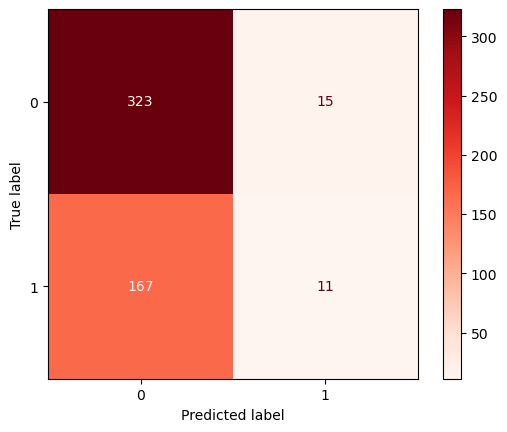

In [26]:
ConfusionMatrixDisplay.from_estimator(gs_model, X_test_ss, y_test, cmap = 'Reds');

# Confusion Matrix Interpretation of Oversampled Logistic Regression
______



## Smarter Move: Grid search with balanced accuracy as your scoring metric

You can change the scoring metric for GridSearchCV. It will then pick the model that hasn't the best mean score on that metric.


In [27]:
gs2 = GridSearchCV(pipe,
                 param_grid=
                  {'randomoversampler__sampling_strategy' : [.25, .5, .75, 1.0]},
                 n_jobs=-1, scoring='balanced_accuracy')

In [28]:
gs2.fit(X_train_ss, y_train)

C:\Users\danie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\danie\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\danie\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\danie\anaconda3\Lib\site-packages\imblearn\pipeline.py", line 322, in fit
    Xt, yt = self._fit(X, y,

GridSearchCV(estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'randomoversampler__sampling_strategy': [0.25, 0.5,
                                                                  0.75, 1.0]},
             scoring='balanced_accuracy')

In [29]:
gs2.best_params_

{'randomoversampler__sampling_strategy': 1.0}

In [30]:
# the best estimator
gs2_model = gs2.best_estimator_

In [31]:
# Train Score 
gs2_model.score(X_train_ss, y_train)

0.53954391072295

In [32]:
# Test Score 
gs2_model.score(X_test_ss, y_test)

0.5562015503875969

In [33]:
preds2 = gs2_model.predict(X_test_ss)

balanced_accuracy: 0.5335915165215079
recall: 0.4606741573033708
precision: 0.3813953488372093
f1 score: 0.41730279898218836


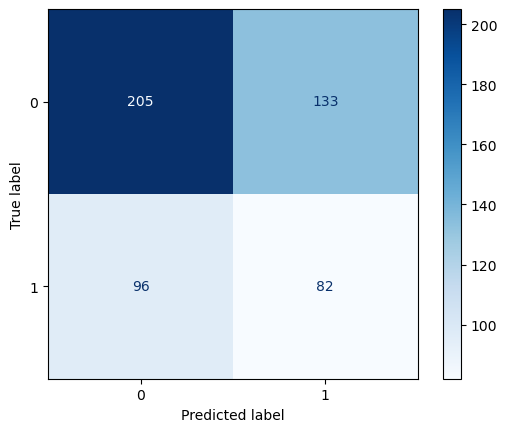

In [34]:
scores.append(evaluation(X_test_ss, y_test, preds2, gs2))

In [35]:
pd.DataFrame(scores, index=['logr', 'RandomOverSampler'])

,balanced_accuracy,recall,precision,f1_score
logr,0.504139,0.011236,0.666667,0.022099
RandomOverSampler,0.533592,0.460674,0.381395,0.417303


# Option 2: Create synthetic data points similar to the minority class
_____

Use SMOTEN method instead since we are dealing with all categorical features

In [36]:
pipe3 = make_pipeline(SMOTEN(random_state=42), LogisticRegression(max_iter=1000))

In [37]:
pipe3

Pipeline(steps=[('smoten', SMOTEN(random_state=42)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [38]:
gs3 = GridSearchCV(
    pipe3, 
    {'smoten__k_neighbors' : [3, 5, 7]
    }, 
    scoring='balanced_accuracy'
)

In [39]:
gs3.fit(X_train_ss, y_train)

GridSearchCV(estimator=Pipeline(steps=[('smoten', SMOTEN(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'smoten__k_neighbors': [3, 5, 7]},
             scoring='balanced_accuracy')

In [40]:
# best parameter for Logistic with SMOTEN
gs3.best_params_

{'smoten__k_neighbors': 5}

In [41]:
# best estimator even though we didn't add much to this
gs3_model = gs3.best_estimator_

In [42]:
# train score
gs3_model.score(X_train_ss, y_train)

0.5400291120815138

In [43]:
# test score
gs3_model.score(X_test_ss, y_test)

0.5562015503875969

balanced_accuracy: 0.5322618176982914
recall: 0.4550561797752809
precision: 0.38028169014084506
f1 score: 0.41432225063938616


{'balanced_accuracy': 0.5322618176982914,
 'recall': 0.4550561797752809,
 'precision': 0.38028169014084506,
 'f1_score': 0.41432225063938616}

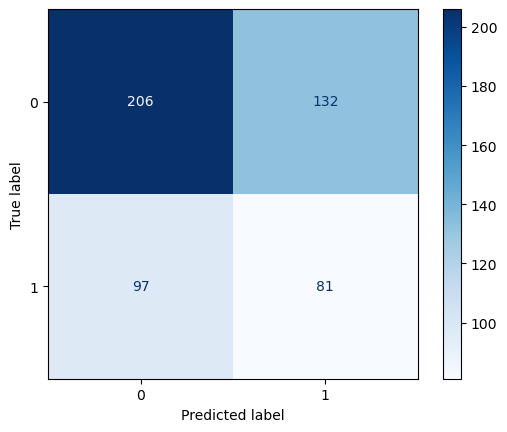

In [44]:
# create prediction
preds3 = gs3_model.predict(X_test_ss)

# find out respective scores
evaluation(X_test_ss, y_test, preds3, gs3_model)

balanced_accuracy: 0.5322618176982914
recall: 0.4550561797752809
precision: 0.38028169014084506
f1 score: 0.41432225063938616


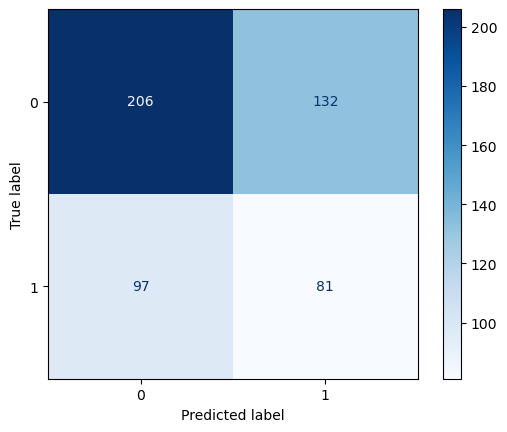

In [45]:
scores.append(evaluation(X_test_ss, y_test, preds3, gs3))

In [46]:
pd.DataFrame(scores, index=['logr', 'RamdomOverSampler', 'SMOTEN'])

,balanced_accuracy,recall,precision,f1_score
logr,0.504139,0.011236,0.666667,0.022099
RamdomOverSampler,0.533592,0.460674,0.381395,0.417303
SMOTEN,0.532262,0.455056,0.380282,0.414322


## ADASYN with Logistic Regression

In [47]:
pipe4 = make_pipeline(ADASYN(random_state=42),
                    LogisticRegression(max_iter=1000))

In [48]:
gs4 = GridSearchCV(
    pipe4, 
    {'adasyn__n_neighbors':[3,5,7],}, 
    scoring='balanced_accuracy',
    n_jobs=-1
)

In [49]:
gs4.fit(X_train_ss, y_train)

GridSearchCV(estimator=Pipeline(steps=[('adasyn', ADASYN(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1, param_grid={'adasyn__n_neighbors': [3, 5, 7]},
             scoring='balanced_accuracy')

In [52]:
# best parameter
gs4.best_params_

{'adasyn__n_neighbors': 7}

In [54]:
# best estimator
gs4_model = gs4.best_estimator_

In [55]:
# train score
gs4_model.score(X_train_ss, y_train)

0.5390587093643863

In [56]:
# test score
gs4_model.score(X_test_ss, y_test)

0.5523255813953488

balanced_accuracy: 0.5266438401702014
recall: 0.4438202247191011
precision: 0.3744075829383886
f1 score: 0.4061696658097686


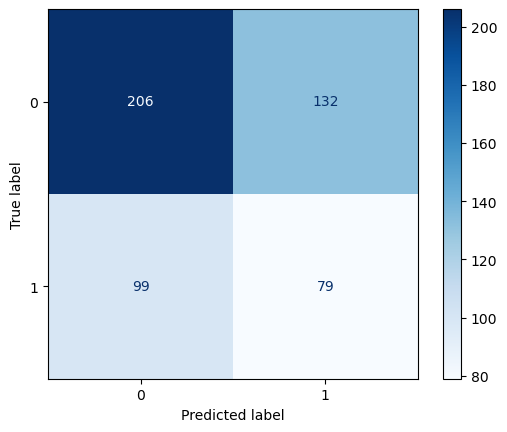

In [57]:
preds4 = gs4_model.predict(X_test_ss)

scores.append(evaluation(X_test_ss, y_test, preds4, gs4))

In [58]:
pd.DataFrame(scores, index = ['logr', 'RandomOverSampler',
                             'SMOTEN', 'ADASYN'])

,balanced_accuracy,recall,precision,f1_score
logr,0.504139,0.011236,0.666667,0.022099
RandomOverSampler,0.533592,0.460674,0.381395,0.417303
SMOTEN,0.532262,0.455056,0.380282,0.414322
ADASYN,0.526644,0.443820,0.374408,0.406170


## Overweighing minority class importance in algorithms

In [59]:
logr5 = LogisticRegression(max_iter=1000, class_weight='balanced')

logr5.fit(X_train_ss, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [61]:
# train score
logr5.score(X_train_ss, y_train)

0.5308102862688016

In [62]:
# test score
logr5.score(X_test_ss, y_test)

0.5542635658914729

balanced_accuracy: 0.5454092148128449
recall: 0.5168539325842697
precision: 0.3898305084745763
f1 score: 0.4444444444444445


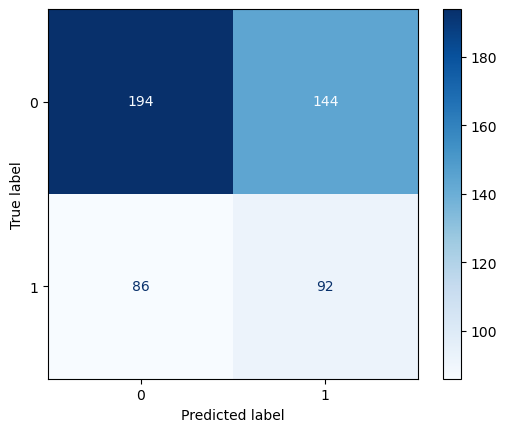

In [63]:
scores.append(evaluation(X_test_ss, y_test, logr5.predict(X_test_ss), logr5))

In [64]:
pd.DataFrame(scores, index=['logr', 'RandomOverSampler', 'SMOTEN', 'ADASYN', 'WeightedLogr'])

,balanced_accuracy,recall,precision,f1_score
logr,0.504139,0.011236,0.666667,0.022099
RandomOverSampler,0.533592,0.460674,0.381395,0.417303
SMOTEN,0.532262,0.455056,0.380282,0.414322
ADASYN,0.526644,0.443820,0.374408,0.406170
WeightedLogr,0.545409,0.516854,0.389831,0.444444


| Model               | Balanced Accuracy | Recall  | Precision | F1 Score |
|---------------------|-------------------|---------|-----------|----------|
| Logistic Regression |                   |         |           |          |
| logr                | 0.504139          | 0.011236| 0.666667  | 0.022099 |
| RandomOverSampler   | 0.533592          | 0.460674| 0.381395  | 0.417303 |
| SMOTE               | 0.532262          | 0.455056| 0.380282  | 0.414322 |
| ADASYN              | 0.526644          | 0.443820| 0.374408  | 0.406170 |
| WeightedLogr        | 0.545409          | 0.516854| 0.389831  | 0.444444 |

| Model          | Balanced Accuracy | Recall  | Precision | F1 Score |
|----------------|-------------------|---------|-----------|----------|
| KNN            |                   |         |           |          |
| knn            | 0.522754          | 0.089888| 0.516129  | 0.153110 |
| RandomOverSampler   | 0.562180          | 0.331461| 0.457364  | 0.384365 |
| SMOTEN              | 0.544728          | 0.320225| 0.422222  | 0.364217 |
| ADASYN              | 0.549315          | 0.314607| 0.434109  | 0.364821 |
| Weightedknn         | 0.539010          | 0.146067| 0.530612  | 0.229075 |

| Model          | Balanced Accuracy | Recall  | Precision | F1 Score |
|----------------|-------------------|---------|-----------|----------|
| Random Forest  |                   |         |           |          |
| rf             | 0.533974          | 0.168539| 0.468750  | 0.247934 |
| RandomOverSampler   | 0.554302          | 0.460674| 0.407960  | 0.432718 |
| SMOTEN              | 0.542916          | 0.443820| 0.395000  | 0.417989 |
| ADASYN              | 0.534456          | 0.539326| 0.376471  | 0.443418 |
| Weightedrf          | 0.535204          | 0.511236| 0.379167  | 0.435407 |

| Model          | Balanced Accuracy | Recall  | Precision | F1 Score |
|----------------|-------------------|---------|-----------|----------|
| ADA Boost      |                   |         |           |          |
| ada            | 0.504720          | 0.044944| 0.400000  | 0.080808 |
| RandomOverSampler   | 0.535520          | 0.443820| 0.385366  | 0.412533 |
| SMOTEN              | 0.519696          | 0.426966| 0.367150  | 0.394805 |
| ADASYN              | 0.516272          | 0.500000| 0.360324  | 0.418824 |
| Weightedada         | 0.531082          | 0.443820| 0.379808  | 0.409326 |

| Model          | Balanced Accuracy | Recall  | Precision | F1 Score |
|----------------|-------------------|---------|-----------|----------|
| SVC            |                   |         |           |          |
| svc            | 0.504139          | 0.011236| 0.666667  | 0.022099 |
| RandomOverSampler   | 0.578685          | 0.544944| 0.425439  | 0.477833 |
| SMOTEN              | 0.556496          | 0.544944| 0.399177  | 0.460808 |
| ADASYN              | 0.536932          | 0.668539| 0.371875  | 0.477912 |
| Weightedsvc         | 0.540523          | 0.533708| 0.383065  | 0.446009 |
